In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from pnu_learning import PNULearning
%matplotlib inline

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

In [3]:
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [4]:
testset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [5]:
trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [6]:
x_train, y_train = trainset.data, trainset.targets

In [7]:
x_test, y_test = testset.data, testset.targets

In [8]:
#label = {0, 1}だけのデータで2値分類に
x_train = np.array(x_train).astype(np.float32) / 255.
y_train = np.array(y_train).reshape(-1)
x_test = np.array(x_test).astype(np.float32) / 255.
y_test = np.array(y_test).reshape(-1)


#label = {0, 1}だけのデータで2値分類
y_train[y_train == 0] = -1
y_train[y_train == 1] = 1
y_test[y_test == 0] = -1
y_test[y_test == 1] = 1


# ラベルごとにデータを分割
positive_indices_train = np.where(y_train == 1)[0]
negative_indices_train = np.where(y_train == -1)[0]
positive_indices_test = np.where(y_test == 1)[0]
negative_indices_test = np.where(y_test == -1)[0]

# ラベル付きデータの数
n_labeled = 100

# 正例のラベル付きデータと負例のラベル付きデータをランダムに選択
np.random.seed(seed=46)
positive_labeled_indices = np.random.choice(positive_indices_train, int(0.5 * n_labeled))
negative_labeled_indices = np.random.choice(negative_indices_train, int(0.5 * n_labeled))

# ラベル付きデータ
x_labeled = np.concatenate((x_train[positive_labeled_indices], x_train[negative_labeled_indices]), axis=0)
y_labeled = np.concatenate((y_train[positive_labeled_indices], y_train[negative_labeled_indices]), axis=0)

# ラベルなしデータ
positive_unlabeled_indices = np.setdiff1d(positive_indices_train, positive_labeled_indices)
negative_unlabeled_indices = np.setdiff1d(negative_indices_train, negative_labeled_indices)
x_unlabeled = np.concatenate((x_train[positive_unlabeled_indices], x_train[negative_unlabeled_indices]), axis=0)
y_unlabeled = np.zeros(len(x_unlabeled))

# 学習データの結合
x_train = np.concatenate((x_labeled, x_unlabeled), axis=0)
y_train = np.concatenate((y_labeled, y_unlabeled), axis=0)

# ラベル付きデータとラベルなしデータの数
n_labeled = len(y_labeled)
n_unlabeled = len(y_unlabeled)

# 学習データの形状
input_shape = x_train.shape[1:]

# 学習データの正例の数と事前確率の計算
n_positive_labeled = np.sum(y_train == 1)
prior = n_positive_labeled / n_labeled

#テストデータ
x_test = x_test[(y_test==1) | (y_test==-1)]
y_test = y_test[(y_test==1) | (y_test==-1)]

In [9]:
prior

0.5

In [10]:
x_train.shape

(12000, 28, 28)

In [11]:
x_test.shape

(2000, 28, 28)

In [12]:
class CNNModel(nn.Module):
    
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(64*6*6,600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 1)
        
    def forward(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = x.view(-1,64*6*6)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    

In [13]:
model = CNNModel()
loss_func = torch.sigmoid
optimizer = optim.Adam
lr = 1e-5
n_epoch = 10
batch_size = 1000

p_ratio = prior
eta = 0.2

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
learner = PNULearning(model=model, loss_func=loss_func, optimizer=optimizer, lr=lr, p_ratio=p_ratio, eta=eta, device=device)

In [16]:
train_loss_history, train_acc_history, train_precision_history, train_recall_history, \
    test_loss_history, test_acc_history, test_precision_history, test_recall_history = learner.fit(x_train, y_train, x_test, y_test, n_epoch, batch_size, threshold=0, verbose=1)

epoch: 1/10


/home/kiryu_asakura_monotaro_com/.local/share/virtualenvs/demand_forecast_DNN-3mvUAJM5/lib/python3.7/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


loss: 0.4882, acc: 0.6944, precision: 0.6875, recall: 0.9167
loss: 0.4965, acc: 0.6058, precision: 0.5917, recall: 0.8333
loss: 0.4875, acc: 0.6731, precision: 0.6438, recall: 0.8750
loss: 0.4825, acc: 0.6785, precision: 0.6400, recall: 0.9000
loss: 0.4773, acc: 0.6987, precision: 0.6583, recall: 0.9167
loss: 0.4750, acc: 0.6942, precision: 0.6357, recall: 0.9286
loss: 0.4723, acc: 0.7116, precision: 0.6396, recall: 0.9375
loss: 0.4670, acc: 0.7436, precision: 0.6796, recall: 0.9444
loss: 0.4633, acc: 0.7492, precision: 0.6917, recall: 0.9300
loss: 0.4596, acc: 0.7720, precision: 0.7197, recall: 0.9364
loss: 0.4562, acc: 0.7910, precision: 0.7431, recall: 0.9417
test_loss: 0.3848, test_acc: 0.9045, test_precision: 0.8615, test_recall: 0.9640
epoch: 2/10
loss: 0.3895, acc: 1.0000, precision: 1.0000, recall: 1.0000
loss: 0.3967, acc: 0.9583, precision: 0.9444, recall: 1.0000
loss: 0.3992, acc: 0.9410, precision: 0.9083, recall: 1.0000
loss: 0.3882, acc: 0.9528, precision: 0.9267, recall:

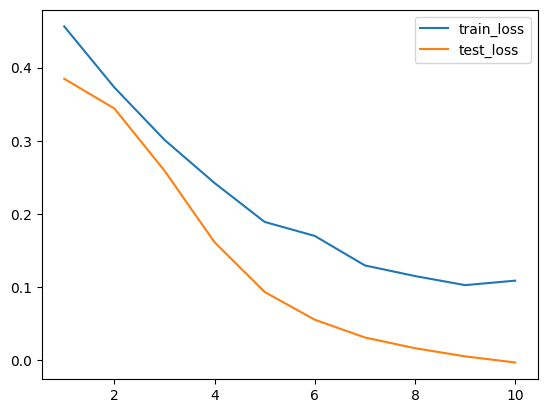

In [17]:
plt.plot([i+1 for i in range(n_epoch)], train_loss_history, label="train_loss")
plt.plot([i+1 for i in range(n_epoch)], test_loss_history, label="test_loss")
plt.legend()
plt.show()

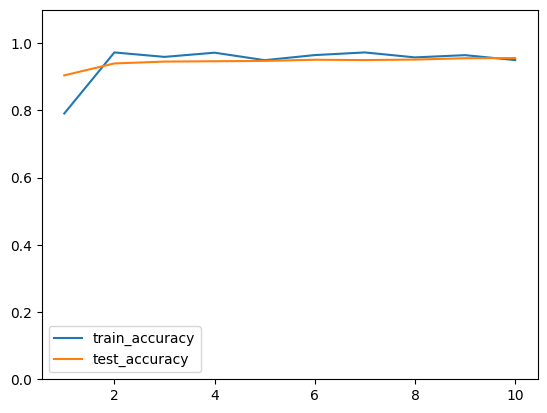

In [18]:
plt.plot([i+1 for i in range(n_epoch)], train_acc_history, label="train_accuracy")
plt.plot([i+1 for i in range(n_epoch)], test_acc_history, label="test_accuracy")
plt.ylim(0, 1.1)
plt.legend()
plt.show()

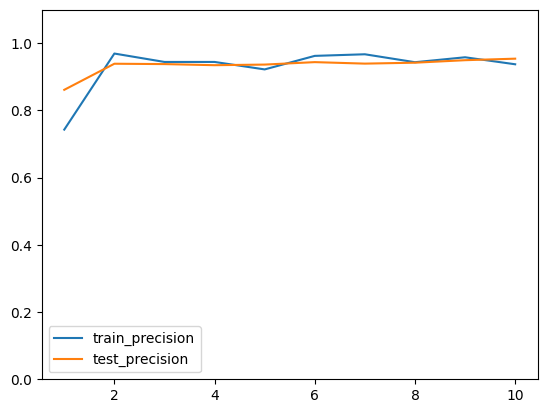

In [19]:
plt.plot([i+1 for i in range(n_epoch)], train_precision_history, label="train_precision")
plt.plot([i+1 for i in range(n_epoch)], test_precision_history, label="test_precision")
plt.ylim(0, 1.1)
plt.legend()
plt.show()

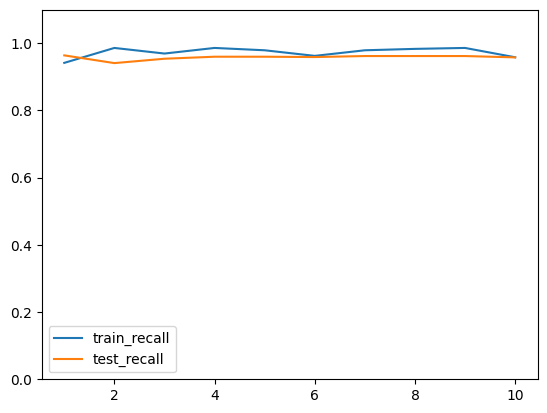

In [20]:
plt.plot([i+1 for i in range(n_epoch)], train_recall_history, label="train_recall")
plt.plot([i+1 for i in range(n_epoch)], test_recall_history, label="test_recall")
plt.ylim(0, 1.1)
plt.legend()
plt.show()

In [21]:
pred = learner.predict(x_test)

In [22]:
print(pred.shape)

torch.Size([2000])
